<a href="https://colab.research.google.com/github/JidaphaMekon/Oppa-Workshop/blob/main/Model_without_interpolation%2BSliding_Window%2BLag_7_days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_market_calendars
!pip install yfinance scikit-learn xgboost matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt

# ไลบรารีสำหรับ Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 8.7 MB/s eta 0:00:00


In [2]:

# ------------------------------
# 0. กำหนด list หุ้นทั้งหมด
# ------------------------------
tickers = ["AAPL", "AMD", "AVGO", "GOOG", "GOOGL", "META", "MSFT", "NVDA"]

# กำหนดช่วงวันที่
start_date = datetime(2019, 1, 1)
end_date   = datetime(2024, 12, 31)

all_data_list = []

# ------------------------------
# 1. ดาวน์โหลดข้อมูลหุ้นทั้งหมด
# ------------------------------
for ticker in tickers:
    print(f"📥 Downloading {ticker} ...")
    data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

    if data.empty:
        print(f"❌ No data for {ticker}")
        continue

    data.reset_index(inplace=True)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in data.columns.values]

    def clean_columns(cols):
        cleaned = []
        for col in cols:
            if 'Date' in col:
                cleaned.append('Date')
            else:
                cleaned.append(col.split()[0])
        return cleaned

    data.columns = clean_columns(data.columns)
    data['Symbol'] = ticker.upper()

    wanted_cols = ['Date', 'Close', 'Symbol']
    data = data[[col for col in wanted_cols if col in data.columns]]

    all_data_list.append(data)

# Concatenate all dataframes in the list into a single dataframe
flat_df = pd.concat(all_data_list, ignore_index=True)

📥 Downloading AAPL ...


/tmp/ipython-input-2479564761.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2479564761.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2479564761.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading AMD ...
📥 Downloading AVGO ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2479564761.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading GOOG ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2479564761.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading GOOGL ...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2479564761.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


📥 Downloading META ...
📥 Downloading MSFT ...


/tmp/ipython-input-2479564761.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2479564761.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))


📥 Downloading NVDA ...


[*********************100%***********************]  1 of 1 completed


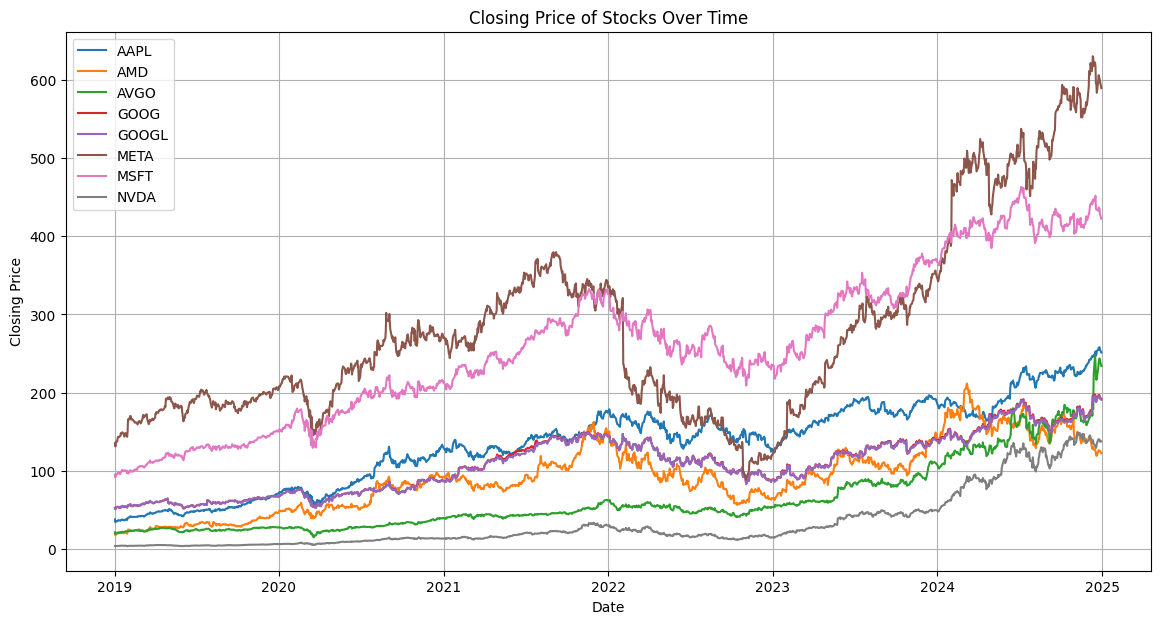

In [3]:
plt.figure(figsize=(14, 7))
for ticker in tickers:
    ticker_df = flat_df[flat_df['Symbol'] == ticker]
    plt.plot(ticker_df['Date'], ticker_df['Close'], label=ticker)

plt.title('Closing Price of Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# ตรวจความเบ้และความโด่ง
print("Skewness and Kurtosis of Closing Prices:")
for ticker in tickers:
    ticker_df = flat_df[flat_df['Symbol'] == ticker]
    skewness = ticker_df['Close'].skew()
    kurtosis = ticker_df['Close'].kurtosis()
    print(f"{ticker}: Skewness = {skewness:.4f}, Kurtosis = {kurtosis:.4f}")

Skewness and Kurtosis of Closing Prices:
AAPL: Skewness = -0.1811, Kurtosis = -0.7798
AMD: Skewness = 0.2708, Kurtosis = -0.6258
AVGO: Skewness = 1.4969, Kurtosis = 1.5172
GOOG: Skewness = 0.1733, Kurtosis = -0.9903
GOOGL: Skewness = 0.1799, Kurtosis = -0.9847
META: Skewness = 0.9960, Kurtosis = 0.2219
MSFT: Skewness = 0.2126, Kurtosis = -0.8723
NVDA: Skewness = 1.7518, Kurtosis = 1.9423
